## NOTE:
If somehow the execution is taking too long in Colab or showing error, please move the code to Text Editor (vscode, sublime, etc.). Already tested it there and it works well.

Don't forget to follow the README.md before starts :)

## Setup

In [1]:
%%shell
# Ubuntu no longer distributes chromium-browser outside of snap
#
# Proposed solution: https://askubuntu.com/questions/1204571/how-to-install-chromium-without-snap

# Add debian buster
cat > /etc/apt/sources.list.d/debian.list <<'EOF'
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster.gpg] http://deb.debian.org/debian buster main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster-updates.gpg] http://deb.debian.org/debian buster-updates main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-security-buster.gpg] http://deb.debian.org/debian-security buster/updates main
EOF

# Add keys
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A

apt-key export 77E11517 | gpg --dearmour -o /usr/share/keyrings/debian-buster.gpg
apt-key export 22F3D138 | gpg --dearmour -o /usr/share/keyrings/debian-buster-updates.gpg
apt-key export E562B32A | gpg --dearmour -o /usr/share/keyrings/debian-security-buster.gpg

# Prefer debian repo for chromium* packages only
# Note the double-blank lines between entries
cat > /etc/apt/preferences.d/chromium.pref << 'EOF'
Package: *
Pin: release a=eoan
Pin-Priority: 500


Package: *
Pin: origin "deb.debian.org"
Pin-Priority: 300


Package: chromium*
Pin: origin "deb.debian.org"
Pin-Priority: 700
EOF

# Install chromium and chromium-driver
apt-get update
apt-get install chromium chromium-driver

# Install selenium
pip install selenium

Executing: /tmp/apt-key-gpghome.2rTN6MOnbU/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
gpg: key DCC9EFBF77E11517: public key "Debian Stable Release Key (10/buster) <debian-release@lists.debian.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Executing: /tmp/apt-key-gpghome.edeQZ5jyuK/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
gpg: key DC30D7C23CBBABEE: public key "Debian Archive Automatic Signing Key (10/buster) <ftpmaster@debian.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Executing: /tmp/apt-key-gpghome.OYVzxQccTR/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A
gpg: key 4DFAB270CAA96DFA: public key "Debian Security Archive Automatic Signing Key (10/buster) <ftpmaster@debian.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Get:1 http://deb.debian.org/debian buster InRelease [122 kB]
Get:2 http://security.ubuntu.com/ubuntu

In [2]:
!pip show selenium

Name: selenium
Version: 4.24.0
Summary: Official Python bindings for Selenium WebDriver
Home-page: https://www.selenium.dev
Author: 
Author-email: 
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: certifi, trio, trio-websocket, typing_extensions, urllib3, websocket-client
Required-by: 


## Implementation

In [3]:
driver_path = "/usr/bin/chromedriver"

In [4]:
# INIT DRIVER
from selenium import webdriver
from selenium.webdriver.chrome.service import Service

def init(driver_path: str, headless: bool, detach: bool) -> webdriver.Chrome:
    service = Service(executable_path=driver_path)
    chrome_options = webdriver.ChromeOptions()
    if headless:
        chrome_options.add_argument('--headless')
    chrome_options.add_experimental_option("detach", detach) # set to 'True' to keep driver "alive"

    chrome_options.add_argument('--no-sandbox')

    driver = webdriver.Chrome(service=service, options=chrome_options)
    return driver

### Open Website using Selenium

In [5]:
driver = init(driver_path, True, False)
inf_path = "/home/infinite_scroll_homepage.jpg"
driver.get("https://the-internet.herokuapp.com/infinite_scroll")
driver.get_screenshot_as_file(inf_path)
driver.quit()

<ipython-input-5-982686013e66>:4: UserWarning: name used for saved screenshot does not match file type. It should end with a `.png` extension
  driver.get_screenshot_as_file(inf_path)


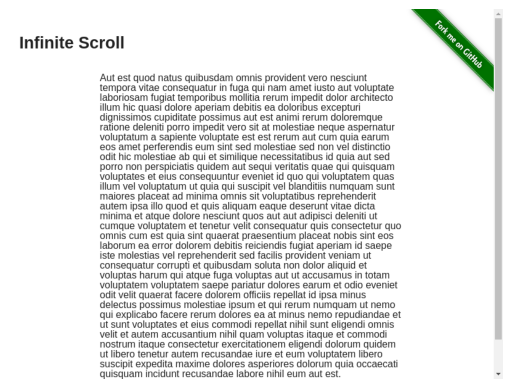

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

for path in [inf_path]:
  img = mpimg.imread(path)
  plt.imshow(img)
  plt.axis('off')
  plt.show()

### How to handle Infinite Scroll in Selenium ?

In [7]:
from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait
import time

def main(driver_path: str, path_to_visit: str):
    # NOTE: FOR EASINESS PURPOSES ON COLLAB, UNCOMMENT THIS LINE AND COMMENT THE LINES BELOW
    print("Initializing driver...")
    driver = init(
        driver_path=driver_path,
        headless=True,
        detach=False
    )
    print("DONE initializing.")

    driver.get(path_to_visit)

    # wait element to be exist
    # Get this XPATH from Google DevConsole
    # 1. Inspect the element you want to get
    # 2. Right click --> Copy as XPATH
    scroll_element_xpath = '//*[@id="content"]/div/div/div/div[@class="jscroll-inner"]'
    init_text = driver.find_element(By.XPATH, scroll_element_xpath)
    init_wait = WebDriverWait(driver, timeout=30)

    print("Waiting the initial text to be displayed before doing infinite scroll")
    init_wait.until(lambda _: init_text.is_displayed())

    # infinite scroll begins
    current_height = driver.execute_script("return document.body.scrollHeight")

    while True:
        print(f"Current height: {current_height}")
        driver.execute_script("window.scroll(0, document.body.scrollHeight);")
        time.sleep(3)

        # let's say we want to stop the scroll after reach at least 10K height (in pixels)
        current_height = driver.execute_script("return document.body.scrollHeight")
        if current_height >= 3500:
            break

    # DO SOMETHING AFTER SCROLL ENDS
    print(f"Latest height: {current_height}")
    return  driver.page_source

In [8]:
path_to_visit = "https://the-internet.herokuapp.com/infinite_scroll"
response_text = main(driver_path, path_to_visit)

Initializing driver...
DONE initializing.
Waiting the initial text to be displayed before doing infinite scroll
Current height: 656
Current height: 1168
Current height: 1696
Current height: 2224
Current height: 2752
Current height: 3280
Latest height: 3824


In [9]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(response_text, 'html.parser')
paragraph = soup.find_all("div", class_="jscroll-added")
len(paragraph)

7

In [12]:
for item in paragraph:
  print(item.text)
  print('\n')

Quaerat non qui odio saepe ut tempore dolores fuga modi laboriosam modi fugiat autem iste quisquam nostrum distinctio sit labore consequatur autem quia earum dignissimos voluptate non et et esse totam aliquid accusantium eos omnis dolore aut nesciunt id ut possimus est est debitis iure sit molestiae eveniet consequatur ullam repudiandae corrupti reprehenderit et accusamus consectetur qui assumenda qui ipsa sunt dolorum et qui veniam quis aspernatur suscipit quos ex culpa deserunt consequatur et sint nobis rem est maiores nesciunt est ullam expedita odit ducimus non non eius et cum ducimus neque porro culpa iste eos itaque omnis nam sit reiciendis quis et et quas eaque voluptatem quidem nulla voluptatem fugit voluptatem nemo quam harum corrupti incidunt laboriosam autem est possimus occaecati repudiandae voluptas ipsa error sint ab doloremque quo id consectetur facere laudantium facere a voluptas aut ea voluptas ratione qui et tempore delectus voluptates quaerat tenetur perspiciatis max

### More Challenging - Do Scraping on Google Maps with Infinite Scroll

In [ ]:
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.wait import WebDriverWait
import pandas_gbq
import pandas as pd
from google.oauth2 import service_account
import time

DATASET_ID = "dibimbing_de_batch4" # NOTE: use underscore, don't use dash (-)
TABLE_ID = "hospitals"

def main(driver_path: str, path_to_visit: str, keyword: str):
    location_names = []
    location_addresses = []

    # NOTE: FOR EASINESS PURPOSES ON COLLAB, UNCOMMENT THIS LINE AND COMMENT THE LINES BELOW
    print("Initializing driver...")
    driver = init(
        driver_path=driver_path,
        headless=True,
        detach=False
    )
    print("DONE initializing.")

    driver.get(path_to_visit)

    # wait for 5 seconds
    time.sleep(5)

    search_bar_xpath = '//*[@id="searchboxinput"]'
    search_el = driver.find_element(By.XPATH, search_bar_xpath)
    # search_el.click()
    search_el.send_keys(keyword)
    search_el.send_keys(Keys.RETURN)
    time.sleep(5)

    # YOU CAN COPY AND PASTE THIS xpath INTO Chrome DevTools > elements to get the selected element
    scroll_xpath = '//*[@id="QA0Szd"]/div/div/div[1]/div[2]/div/div[1]/div/div/div[2]/div[1]'
    scroll_el = driver.find_element(By.XPATH, scroll_xpath)
    init_wait = WebDriverWait(driver, timeout=30)

    # print("Waiting the initial text to be displayed before doing infinite scroll")
    # init_wait.until(lambda _: scroll_el.is_displayed())

    i = 0
    while i <=15:
        print(i)
        i += 1
        driver.execute_script("arguments[0].scrollIntoView(true);", driver.find_element(By.XPATH, scroll_xpath))
        time.sleep(5)

        # most_bottom_el = driver.find_element(By.XPATH, '//*[@id="QA0Szd"]/div/div/div[1]/div[2]/div/div[1]/div/div/div[2]/div[1]/div[last()]')

        # if most_bottom_el.text.strip().lower() == 'anda telah mencapai akhir daftar.':
            # break

    locations_el = driver.find_elements(By.XPATH, '//*[@class="Nv2PK tH5CWc THOPZb "]')
    print(f"There are {len(locations_el)} locations found with '{keyword}' keyword")

    for loc_element in locations_el:
        name_el = loc_element.find_element(By.XPATH, ".//a[contains(@href, 'google.co.id')]")
        name = name_el.get_attribute('aria-label')
        address_el = loc_element.find_element(By.XPATH, './/div[@class="bfdHYd Ppzolf OFBs3e  "]//div[contains(@class, "fontBodyMedium")]')

        location_names.append(name)
        location_addresses.append(address_el.text)

    df = pd.DataFrame({
        "name": location_names,
        "address": location_addresses,
        "keyword": [keyword for _ in range(len(location_names))]
    })
    df.to_csv('results.csv', index=False)

### What About write our scrape results to BigQuery as Raw Table ?

In [ ]:
path_to_visit = "https://www.google.co.id/maps"
keyword = 'Hospital near jakarta'
main(d3river_path, path_to_visit, keyword)

Initializing driver...
DONE initializing.
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
There are 6 locations found with 'Hospital near jakarta' keyword
